<a href="https://colab.research.google.com/github/KryssyCo/DS-Unit-2-Kaggle-Challenge/blob/master/Krista_Shepard_DSPT2_U2S6M2_Assignment_2_Kaggle_Challenge_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Kaggle Challenge, Module 2

## Assignment
- [X] Read [“Adopting a Hypothesis-Driven Workflow”](https://outline.com/5S5tsB), a blog post by a Lambda DS student about the Tanzania Waterpumps challenge.
- [X] Continue to participate in our Kaggle challenge.
- [X] Try Ordinal Encoding.
- [X] Try a Random Forest Classifier.
- [X] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [X] Commit your notebook to your fork of the GitHub repo.

## Stretch Goals

### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Do more exploratory data analysis, data cleaning, feature engineering, and feature selection.
- [X] Try other [categorical encodings](https://contrib.scikit-learn.org/categorical-encoding/).
- [ ] Get and plot your feature importances.
- [ ] Make visualizations and share on Slack.

### Reading

Top recommendations in _**bold italic:**_

#### Decision Trees
- A Visual Introduction to Machine Learning, [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/),  and _**[Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)**_
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU)

#### Random Forests
- [_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/), Chapter 8: Tree-Based Methods
- [Coloring with Random Forests](http://structuringtheunstructured.blogspot.com/2017/11/coloring-with-random-forests.html)
- _**[Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)**_

#### Categorical encoding for trees
- [Are categorical variables getting lost in your random forests?](https://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests/)
- [Beyond One-Hot: An Exploration of Categorical Variables](http://www.willmcginnis.com/2015/11/29/beyond-one-hot-an-exploration-of-categorical-variables/)
- _**[Categorical Features and Encoding in Decision Trees](https://medium.com/data-design/visiting-categorical-features-and-encoding-in-decision-trees-53400fa65931)**_
- _**[Coursera — How to Win a Data Science Competition: Learn from Top Kagglers — Concept of mean encoding](https://www.coursera.org/lecture/competitive-data-science/concept-of-mean-encoding-b5Gxv)**_
- [Mean (likelihood) encodings: a comprehensive study](https://www.kaggle.com/vprokopev/mean-likelihood-encodings-a-comprehensive-study)
- [The Mechanics of Machine Learning, Chapter 6: Categorically Speaking](https://mlbook.explained.ai/catvars.html)

#### Imposter Syndrome
- [Effort Shock and Reward Shock (How The Karate Kid Ruined The Modern World)](http://www.tempobook.com/2014/07/09/effort-shock-and-reward-shock/)
- [How to manage impostor syndrome in data science](https://towardsdatascience.com/how-to-manage-impostor-syndrome-in-data-science-ad814809f068)
- ["I am not a real data scientist"](https://brohrer.github.io/imposter_syndrome.html)
- _**[Imposter Syndrome in Data Science](https://caitlinhudon.com/2018/01/19/imposter-syndrome-in-data-science/)**_






### Setup

You can work locally (follow the [local setup instructions](https://lambdaschool.github.io/ds/unit2/local/)) or on Colab (run the code cell below).

In [1]:
import os, sys
in_colab = 'google.colab' in sys.modules

# If you're in Colab...
if in_colab:
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge.git
    !git pull origin master
    
    # Install required python packages
    !pip install -r requirements.txt
    
    # Change into directory for module
    os.chdir('module2')

Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
From https://github.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge
 * branch            master     -> FETCH_HEAD
Already up to date.


In [0]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import category_encoders as ce 
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler

In [0]:
# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv('../data/tanzania/train_features.csv'), 
                 pd.read_csv('../data/tanzania/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv('../data/tanzania/test_features.csv')
sample_submission = pd.read_csv('../data/tanzania/sample_submission.csv')

In [0]:
# import pandas_profiling
# pandas_profiling.ProfileReport(train)

### Do train/val/test split

In [5]:
train,val = train_test_split(train, train_size=0.80, test_size=0.20,
                             stratify=train['status_group'], random_state=42)
train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

### Data Wrangling

In [0]:
def wrangle(X):
  X = X.copy()
#   small coordinate values to 0
  X['latitude'] = X['latitude'].replace(-2e-08, 0)
  
#   replacing zeroes with mean values
  cols_with_zeroes = ['construction_year', 'longitude', 'latitude', 'gps_height', 'population']
  for col in cols_with_zeroes:
    X[col] = X[col].replace(0, np.nan)
    X[col] = X[col].fillna(X[col].mean())
    
#     date recorded to date time format
  X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
  
# Extract components from date_recorded, then drop the original column
  X['year_recorded'] = X['date_recorded'].dt.year
  X['month_recorded'] = X['date_recorded'].dt.month
  X['day_recorded'] = X['date_recorded'].dt.day
  X = X.drop(columns='date_recorded')
    
# engineer features how many years from construction_year to date_recorded
  X['years'] = X['year_recorded'] - X['construction_year']
  
# dropping features
  X = X.drop(columns= ['payment', 'num_private', 
                       'extraction_type_group','wpt_name', 'ward', 'extraction_type_class',
                       'quality_group', 'source','management', 'management_group',
                      'waterpoint_type_group', 'recorded_by', 'district_code',
                      'region', 'lga', 'id', 'region_code', 
                       'district_code', 'quality_group'])
  
#   Drop duplicate columns
  X = X.drop(columns = ['quantity_group', 'payment_type',
                      'waterpoint_type', 'source_type'])
  
#   for categoricals with missing values fill with 'missing'
  categoricals = X.select_dtypes(exclude='number').columns
  for col in categoricals:
    X[col] = X[col].fillna('MISSING')
    
  return X

train = wrangle(train)
val = wrangle(val)
test= wrangle(test)


### Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a Random Forest classifier.

In [0]:
# Select Features

# define the target
target = 'status_group'

# get a dataframe with all train columns except target
train_features = train.drop(columns=[target])

# get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# get a list of all categorical features with cardinality <=50
categorical_features = cardinality[cardinality <=50].index.tolist()

# combine the lists
features = numeric_features + categorical_features

In [0]:
# arrange data into X features matrix and y vector
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [0]:
# # make a pipeline with OneHotEncoder
# pipeline = make_pipeline(
#     ce.OneHotEncoder(),
#     SimpleImputer(strategy='median),
#     RandomForestClassifier(n_estimators=1000, min_samples_split = 20,
#                            random_state=42, n_jobs=-1)
# )


In [0]:
# # fit on train
# # score on val
# pipeline.fit(X_train, y_train)
# print('Validation Accuracy', pipeline.score(X_val, y_val))
# ypred = pipeline.predict(X_test)

# ## Validation Accuracy 0.8022727272727272

In [0]:
# make a pipeline with ordinal encoder
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_estimators=1000, min_samples_split=2,
                              max_depth = 20, random_state=42, n_jobs=-1,)
)

In [11]:
# fit on train score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))
y_pred = pipeline.predict(X_test)

Validation Accuracy 0.8104377104377104


### Kaggle Submission code

In [0]:
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('submission-07.csv', index=False)

In [0]:
from google.colab import files
files.download('submission-07.csv')

## Stretch Goals 

 

*  Get and plot your feature importances.






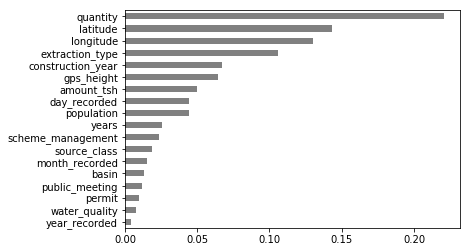

In [16]:
# Plot feature importances using Decision tree and ordinal encoder
from sklearn.tree import DecisionTreeClassifier

pipeline = make_pipeline(
    
    ce.OrdinalEncoder(),
    SimpleImputer(),
    DecisionTreeClassifier(max_depth=15, random_state=42)

)
pipeline.fit(X_train, y_train)

model = pipeline.named_steps['decisiontreeclassifier']
encoder = pipeline.named_steps['ordinalencoder']
encoded_columns = encoder.transform(X_train).columns 
importances = pd.Series(model.feature_importances_, encoded_columns)
importances.sort_values().plot.barh(color='grey')

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


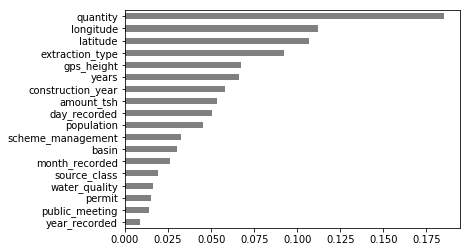

In [17]:
# Plot feature importances using Random Forestand ordinal encoder
from sklearn.tree import DecisionTreeClassifier

pipeline = make_pipeline(
    
    ce.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(max_depth=15, random_state=42)

)
pipeline.fit(X_train, y_train)

model = pipeline.named_steps['randomforestclassifier']
encoder = pipeline.named_steps['ordinalencoder']
encoded_columns = encoder.transform(X_train).columns 
importances = pd.Series(model.feature_importances_, encoded_columns)
importances.sort_values().plot.barh(color='grey')

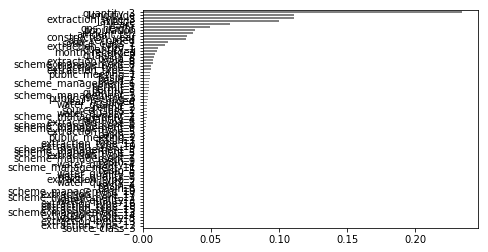

In [18]:
# Plot your feature importances using Decision tree and one hot encoder
from sklearn.tree import DecisionTreeClassifier

pipeline = make_pipeline(
    
    ce.OneHotEncoder(),
    SimpleImputer(),
    DecisionTreeClassifier(max_depth=15, random_state=42)

)
pipeline.fit(X_train, y_train)

model = pipeline.named_steps['decisiontreeclassifier']
encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_train).columns 
importances = pd.Series(model.feature_importances_, encoded_columns)
importances.sort_values().plot.barh(color='grey')

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


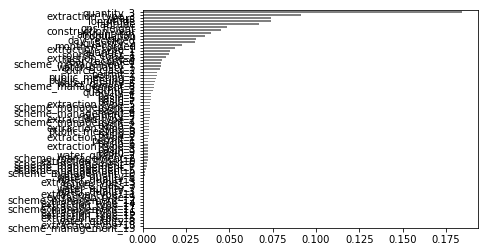

In [19]:
# Plot feature importances using Random Forest and one hot encoder

pipeline = make_pipeline(
    
    ce.OneHotEncoder(),
    SimpleImputer(),
    RandomForestClassifier(max_depth=15, random_state=42)

)
pipeline.fit(X_train, y_train)

model = pipeline.named_steps['randomforestclassifier']
encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_train).columns 
importances = pd.Series(model.feature_importances_, encoded_columns)
importances.sort_values().plot.barh(color='grey')

### My conclusion is that ordinal encoding presents a more readable visualization when compared to OneHotEncoding.

## *  Make visualizations and share on Slack.



In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)

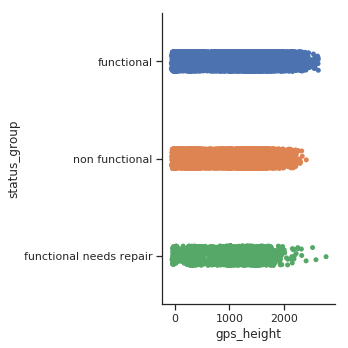

In [28]:
sns.catplot(x="gps_height", y="status_group", data=train);

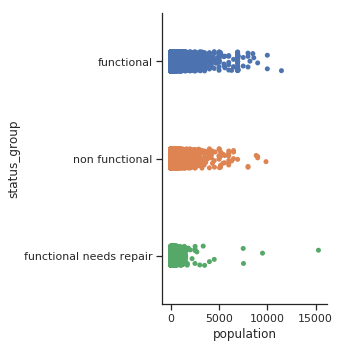

In [29]:
sns.catplot(x="population", y="status_group", data=train);